In [1]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import TimeSeriesSplit
from math import sqrt
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from util_functions import get_prepare_data, shift_values, cv_score_average
from deeplearning_util import TimeSeriesDataset, train_model, descale, print_loss_metrics, predict

from tqdm import tqdm
import random

/home/czfire/.local/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This took way too much time ...

I just used the day data set because my PC doesn't have enough disk space to handle 50 Gigs. So could someone please Change this to hourly :)

As the easy machine learning models can't use previous rows to learn a value. I shifted the rows. In this example I shifted the rows so that the model has the y-value "prec" with three rows of old data. This can be seen in the function shift_values in util_functions.py. Can someone please Change this to Hours and Maybe to 6 Hours (ergo 6 rows?

I only did the models for each file indivudally. It would be nice if someone of you guys could make a model so it combines multiple files, aka water Sources.

Otherwise everything works

In [2]:
MIN_DATA_SAMPLE = 1
MAX_DATA_SAMPLE = 882

In [3]:
import os

Data_path = "./dataset/B_basins_intermediate_all/2_timeseries/hourly/"

in_dir = os.listdir(Data_path)
files = [f"ID_{id}.csv" for id in range(MIN_DATA_SAMPLE, MAX_DATA_SAMPLE + 1)]

id_blacklist = []

for file in files:
    if file not in in_dir:
        id_blacklist.append(int(file[len("ID_"):-len(".csv")]))

print(id_blacklist)

[31, 146, 353, 362, 365, 369, 400, 417, 418, 419, 420, 421, 424, 425, 427, 502, 522, 727, 745, 765, 775, 781, 794]


https://stackoverflow.com/questions/61300023/how-to-combine-static-features-with-time-series-in-forecasting

https://towardsdatascience.com/multi-step-time-series-forecasting-with-xgboost-65d6820bec39

In [4]:
seed_number = 2022
rng = np.random.default_rng(seed=seed_number)
id_list = rng.integers(low=MIN_DATA_SAMPLE, high=MAX_DATA_SAMPLE, size=100) # We can only take 100 samples from the the timeseries data. Therefor we generate 100 random integers from 1 to 882

for index, value in enumerate(id_list):
    while value in id_blacklist:
        value = random.randint(MIN_DATA_SAMPLE, MAX_DATA_SAMPLE)
    
    id_list[index] = value

file_names = [f"ID_{id}.csv" for id in id_list]
models = ["xgb", "RandomForrest", "DecisionTree", "LinearRegression"] # I removed SGD from this list, as it has an absurdly high error number
tss = TimeSeriesSplit(n_splits=5)

In [5]:
scores = {}
for file_name in tqdm(file_names):
    df = get_prepare_data(Data_path=Data_path, filename=file_name, cut_data=True)
    df_shifted = shift_values(df=df)

    df_shifted = df_shifted.select_dtypes(exclude=["datetime64[ns]"])
    
    features = list(df_shifted.columns)#.remove("prec")
    features.remove("prec")
    target = "prec"
    
    scores_temp = {}
    for model in models:
        scores_temp[model] = cv_score_average(df_shifted, model, tss, features, target)
    scores[file_name] = scores_temp

100%|██████████| 100/100 [07:36<00:00,  4.57s/it]


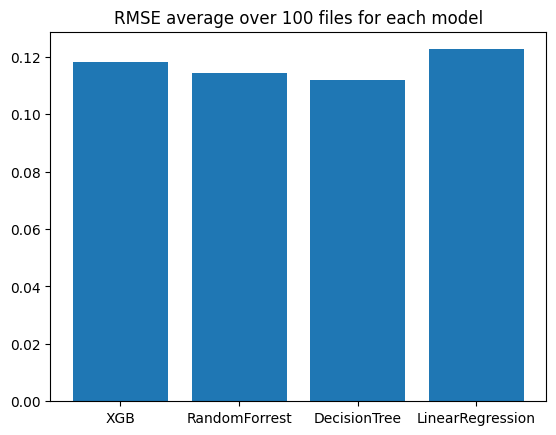

In [6]:
xgb_scores = []
rf_scores = []
dec_tree_scores = []
lin_reg_scores = []

for filename in file_names:
    xgb_scores.append(scores[file_name]["xgb"])
    rf_scores.append(scores[file_name]["RandomForrest"])
    dec_tree_scores.append(scores[file_name]["DecisionTree"])
    lin_reg_scores.append(scores[file_name]["LinearRegression"])

finals_scores = {"XGB": np.average(xgb_scores), "RandomForrest": np.average(rf_scores), "DecisionTree": np.average(dec_tree_scores), "LinearRegression": np.average(lin_reg_scores)}

_ = plt.bar(*zip(*finals_scores.items()))
_ = plt.title("RMSE average over 100 files for each model")

**Important!**

Now that we have shifted the data, we can predict with the data from the last three days. In our data frame we don't have the data from the day in which the prec was meassured, but only the data from the meassurements of the last three days 

--------------

### Deep learning

In [5]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) # I get some weird userwarnings when using RNN 

https://towardsdatascience.com/multivariate-time-series-forecasting-with-deep-learning-3e7b3e2d2bcf

In [17]:
parameters = {
    'train_frac' : 0.5,
    'sequence_length' : 3,
    'batch_size' : 1024,
    'n_epochs' : 20,
    'n_epochs_stop' : 5,
    'background_data_size' : 900,
    'test_sample_size' : 100,
    "path" : "./"
}

In [ ]:
scores_deeplearning = {}
for file_name in tqdm(file_names):
    df = get_prepare_data(Data_path=Data_path, filename=file_names[1], cut_data=False)
    features = list(df.columns)
    features.remove("prec")

    scores_lstm = []
    scores_rnn = []

    scaler = MinMaxScaler()
    scaler = scaler.fit(df)

    for train_idx, val_idx in tss.split(df):    
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]
        train_scaled = pd.DataFrame(scaler.transform(train), index=train.index, columns=train.columns)
        test_scaled = pd.DataFrame(scaler.transform(test), index=train.index, columns=train.columns)

        train_model(train_scaled, test_scaled, features, parameters, model_name="LSTM")
        pred_lstm, truth_lstm = predict(test_scaled, parameters, features, scaler, model_name="LSTM")
        scores_lstm.append(mean_squared_error(pred_lstm.tolist(), truth_lstm.tolist(), squared=False))
        
        train_model(train_scaled, test_scaled, features, parameters, model_name="GRU")
        pred_rnn, truth_rnn = predict(test_scaled, parameters, features, scaler, model_name="GRU")
        scores_rnn.append(mean_squared_error(pred_rnn.tolist(), truth_rnn.tolist(), squared=False))
        break

    scores_deeplearning[file_name] = {"LSTM": np.average(scores_lstm), "RNN": np.average(scores_rnn)}

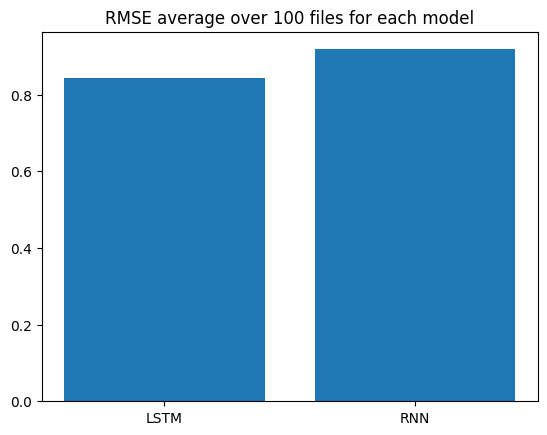

In [8]:
lstm_scores = []
rnn_scores = []
for file_name in file_names[1:3]:
    lstm_scores.append(scores_deeplearning[file_name]["LSTM"])
    rnn_scores.append(scores_deeplearning[file_name]["RNN"])

finals_scores = {"LSTM": np.average(lstm_scores), "RNN": np.average(rnn_scores)}

_ = plt.bar(*zip(*finals_scores.items()))
_ = plt.title("RMSE average over 100 files for each model")